In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/Users/rami/BRI_Price_Omit2.csv')
df.head()


,Unnamed: 0,BBRI.JK.Open,BBRI.JK.High,BBRI.JK.Low,BBRI.JK.Close,BBRI.JK.Volume,BBRI.JK.Adjusted
0,1,1360,1370,1350,1360,15835000.0,585.226135
1,2,1380,1390,1360,1380,81980000.0,593.832397
2,3,1390,1390,1370,1390,151180000.0,598.135620
3,4,1390,1400,1370,1390,134337500.0,598.135620
4,5,1380,1400,1370,1380,105145000.0,593.832397


In [3]:
df = df['BBRI.JK.Close'].values
df = df.reshape(-1, 1)
print(df.shape)
df[:5]

(1253, 1)


array([[1360],
       [1380],
       [1390],
       [1390],
       [1380]])

After reshaping the data. I will know split the data to a training and testing subset. 

For this LSTM we will use the first 50 closing prices to predict the closing price at time 51. 
so, in order to predict the stock price at time t we will use the closing prices from t-50 to t-1 

In [4]:
dataset_train = np.array(df[:int(df.shape[0]*0.9)])
dataset_test = np.array(df[int(df.shape[0]*0.9)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(1127, 1)
(176, 1)


In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[0.19314642],
       [0.20560748],
       [0.21183801],
       [0.21183801],
       [0.20560748]])

In [6]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:5]

array([[0.66666667],
       [0.6728972 ],
       [0.6728972 ],
       [0.63862928],
       [0.63239875]])

In [7]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [8]:
x_train, y_train = create_dataset(dataset_train)
x_train[:1]

array([[0.19314642, 0.20560748, 0.21183801, 0.21183801, 0.20560748,
        0.21806854, 0.22429907, 0.21806854, 0.20560748, 0.19937695,
        0.19314642, 0.21183801, 0.22429907, 0.23676012, 0.22429907,
        0.21806854, 0.21183801, 0.21806854, 0.21806854, 0.20560748,
        0.19937695, 0.22429907, 0.2305296 , 0.23676012, 0.21806854,
        0.19937695, 0.23676012, 0.21183801, 0.17445483, 0.19937695,
        0.18068536, 0.17445483, 0.18691589, 0.19314642, 0.19314642,
        0.20560748, 0.21183801, 0.19937695, 0.19314642, 0.17445483,
        0.17445483, 0.20560748, 0.18068536, 0.17445483, 0.17445483,
        0.1682243 , 0.14953271, 0.14330218, 0.14953271, 0.17445483]])

In [9]:
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[0.66666667, 0.6728972 , 0.6728972 , 0.63862928, 0.63239875,
        0.60436137, 0.58878505, 0.59813084, 0.61682243, 0.62305296,
        0.63239875, 0.64174455, 0.65420561, 0.64485981, 0.62928349,
        0.61993769, 0.63862928, 0.67601246, 0.69158879, 0.68535826,
        0.76012461, 0.7788162 , 0.78504673, 0.76323988, 0.7788162 ,
        0.77570093, 0.81619938, 0.82554517, 0.7788162 , 0.7694704 ,
        0.76012461, 0.78504673, 0.79127726, 0.76635514, 0.78193146,
        0.80685358, 0.80996885, 0.79750779, 0.81619938, 0.83800623,
        0.85981308, 0.8411215 , 0.8411215 , 0.82866044, 0.83489097,
        0.8411215 , 0.85358255, 0.85358255, 0.8411215 , 0.82242991]])

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [24]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))

In [25]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Train on 1077 samples, validate on 126 samples
Epoch 1/100
1077/1077 [==============================] - 6s 5ms/step - loss: 0.0799 - val_loss: 0.0032
Epoch 2/100
1077/1077 [==============================] - 4s 4ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 3/100
1077/1077 [==============================] - 4s 4ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 4/100
1077/1077 [==============================] - 4s 3ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 5/100
1077/1077 [==============================] - 4s 4ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 6/100
1077/1077 [==============================] - 4s 4ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 7/100
1077/1077 [==============================] - 4s 3ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 8/100
1077/1077 [==============================] - 5s 5ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 9/100
1077/1077 [==============================] - 4s 4ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 10/100
1077/1077 [==

In [27]:
import matplotlib.pyplot as plt

In [28]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

In [29]:
epoch_count = range(1, len(training_loss) + 1)

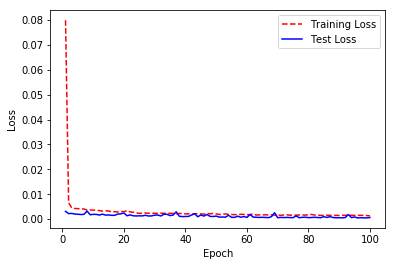

In [30]:
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

I will know plot the predicted closing prices in blue against the true closing price in red. 
Our results show that the LSTM was able to predict very well. But this graph is too zoomed out and in order to have a better look at the results, we will examin the results for just the period where we predicted closing stock price  

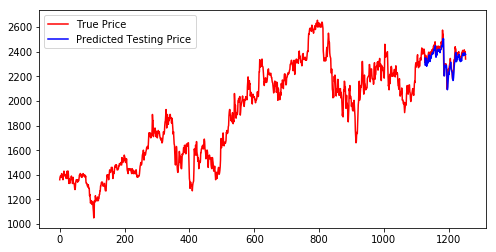

In [31]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

In [32]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

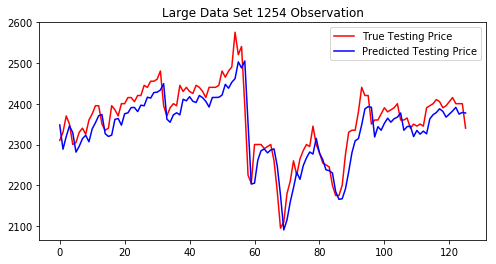

In [37]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax=plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label = 'True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.title('True vs Predicted Testing Price')
plt.legend()
plt.savefig("Project_Final.png")